In [628]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [629]:
import os
DIR = "/content/drive/MyDrive/Finance Files"
os.chdir(DIR)

In [630]:
# Import Libraries

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' %x)

In [631]:
#print("\nCash Flow Statement Keys:")
#print(cash_flow.index)

In [632]:
# Define the ticker symbol
ticker = 'WALMEX.MX' # <----- Change the Ticker for any company

# Fetch the financials
stock = yf.Ticker(ticker)

# Get the Income Statement
income_stmt = stock.financials
#print("Income Statement Keys:")
#print(income_stmt.index)

# Get the Cash Flow Statement
cash_flow = stock.cashflow
#print("\nCash Flow Statement Keys:")
#print(cash_flow.index)

# Calculate the required metrics
revenue = income_stmt.loc['Total Revenue']
operating_income = income_stmt.loc['Operating Income']
operating_margin = operating_income / revenue

# Adjust the key for tax expense based on available keys
tax_expense = income_stmt.loc['Tax Provision']  # Adjusted key
tax_rate = tax_expense / operating_income

depreciation = cash_flow.loc['Depreciation And Amortization'] # Normally just 'Depreciation', but if error appears use print(cash_flow.index) to see the keys
capex = cash_flow.loc['Net PPE Purchase And Sale']
changes_in_working_capital = cash_flow.loc['Change In Working Capital']
fcff = operating_income *(1 -tax_rate) + depreciation + capex + changes_in_working_capital

# Create a DataFrame
df = pd.DataFrame({
    'Revenue': revenue,
    'EBIT': operating_income,
    'Operating Margin': operating_margin,
    'Tax Expense': -tax_expense,
    'Tax Rate': tax_rate,
    'Depreciation': depreciation,
    'CapEx': capex,
    'Change in Working Capital': changes_in_working_capital,
    'FCFF': fcff

})

df = df.T

#df.columns = df.columns.astype(str)
#df = df.applymap(lambda x: f"{x:,.2f}")

# Adjust the order of the Historic Data depending of how is reported
df.columns = pd.to_datetime(df.columns)

# Corrected if statement
if (df.columns[1] - df.columns[0]).days < 0:
    df = df[df.columns[3::-1]]
else:
    df = df.dropna(axis=1, how='all')

print("\nFinancial Data:")
df


Financial Data:


,2020-12-31,2021-12-31,2022-12-31,2023-12-31
Revenue,701092586000.00,735197307000.00,818225636000.00,885739821000.00
EBIT,57447281000.00,62907658000.00,68011617000.00,73275983000.00
Operating Margin,0.08,0.09,0.08,0.08
Tax Expense,-16029226000.00,-13157576000.00,-14392375000.00,-17016748000.00
Tax Rate,0.28,0.21,0.21,0.23
Depreciation,17939624000.00,18305881000.00,19359205000.00,20577439000.00
CapEx,-16330230000.00,-20077816000.00,-20844337000.00,-28479210000.00
Change in Working Capital,4343446000.00,-3670026000.00,-6662570000.00,9847893000.00
FCFF,47370895000.00,44308121000.00,45471540000.00,58205357000.00


In [633]:
# Forecast assumptions
cagr = (df.loc['Revenue'].iloc[-1] / df.loc['Revenue'].iloc[0]) ** (1 / (len(df.loc['Revenue'])-1)) -1
avg_margin = df.loc['Operating Margin'].mean()

country = stock.info.get('country', 'N/A')

# Determine the risk-free rate based on the country
if country == 'United States':
    # Get the latest ^TNX value
    marginal_tax_rate = 0.21
else:
    # Prompt user to input the risk-free rate
    marginal_tax_rate = float(input("Please enter the Tax Rate of your Country: ")) / 100
avg_depreciation = (df.loc['Depreciation'] / df.loc['Revenue']).mean()
avg_capex = (df.loc['CapEx'] / df.loc['Revenue']).mean()
avg_wc_change = (df.loc['Change in Working Capital'] / df.loc['Revenue']).mean()

# Forecast for the next years
forecast_years = 10 # <--- Here change the number the years to forecast
forecast_dates = pd.date_range(start=pd.to_datetime(df.columns[-1]) + pd.DateOffset(years=1), periods=forecast_years, freq='Y')
forecast_df = pd.DataFrame(index=range(1, forecast_years + 1))

forecast_df['Revenue'] = df.loc['Revenue'].iloc[-1] * ((1 + cagr) ** forecast_df.index)
forecast_df['EBIT'] = forecast_df['Revenue'] * avg_margin
forecast_df['Operating Margin'] = avg_margin
forecast_df['Tax Expense'] = forecast_df['EBIT'] * marginal_tax_rate
forecast_df['Tax Rate'] = marginal_tax_rate
forecast_df['Depreciation'] = forecast_df['Revenue'] * avg_depreciation
forecast_df['CapEx'] = forecast_df['Revenue'] * avg_capex
forecast_df['Change in Working Capital'] = forecast_df['Revenue'] * avg_wc_change
forecast_df['FCFF'] = forecast_df['EBIT'] * (1 - forecast_df['Tax Rate']) + forecast_df['Depreciation'] + forecast_df['CapEx'] + forecast_df['Change in Working Capital']

# Set forecast index to dates and format values
forecast_df.index = forecast_dates
#forecast_df = forecast_df.applymap(lambda x: f"{x:,.2f}")


print("\nForecast Data:")
forecast_df.T

Please enter the Tax Rate of your Country: 30

Forecast Data:


,2024-12-31,2025-12-31,2026-12-31,2027-12-31,2028-12-31,2029-12-31,2030-12-31,2031-12-31,2032-12-31,2033-12-31
Revenue,957524221348.88,1035126357347.99,1119017724864.53,1209708031944.19,1307748295700.55,1413734190190.59,1528309665617.42,1652170860849.55,1786070333028.73,1930821629964.50
EBIT,79798812358.64,86266072560.68,93257469066.07,100815480274.61,108986027229.61,117818752625.48,127367322427.31,137689751935.07,148848758273.62,160912141450.05
Operating Margin,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
Tax Expense,23939643707.59,25879821768.21,27977240719.82,30244644082.38,32695808168.88,35345625787.65,38210196728.19,41306925580.52,44654627482.09,48273642435.02
Tax Rate,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30,0.30
Depreciation,23310754330.40,25199964323.69,27242284523.04,29450123678.80,31836896203.14,34417103673.47,37206422941.24,40221801381.55,43481559862.17,47005504057.67
CapEx,-25908220448.95,-28007940959.35,-30277832409.54,-32731686229.64,-35384411570.31,-38252125887.82,-41352252870.74,-44703628302.92,-48326614506.16,-52243224057.82
Change in Working Capital,1000355182.94,1081428535.68,1169072443.19,1263819413.25,1366245110.48,1476971854.00,1596672398.51,1726074021.84,1865962943.71,2017189102.69
FCFF,54262057715.44,58659702692.50,63413752902.94,68553093054.62,74108948804.04,80115076477.49,86607968168.13,93627073455.01,101215039091.24,109417968117.57


In [634]:
# Merge historical and forecast data
combined_df = pd.concat([df, forecast_df.T], axis=1)

for col in df.columns:
    combined_df[col] = combined_df[col].replace(',', '', regex=True).astype(float).round(2)

combined_df = combined_df.T

print("\nCombined Historical and Forecast Data:")
combined_df


Combined Historical and Forecast Data:


,Revenue,EBIT,Operating Margin,Tax Expense,Tax Rate,Depreciation,CapEx,Change in Working Capital,FCFF
2020-12-31,701092586000.00,57447281000.00,0.08,-16029226000.00,0.28,17939624000.00,-16330230000.00,4343446000.00,47370895000.00
2021-12-31,735197307000.00,62907658000.00,0.09,-13157576000.00,0.21,18305881000.00,-20077816000.00,-3670026000.00,44308121000.00
2022-12-31,818225636000.00,68011617000.00,0.08,-14392375000.00,0.21,19359205000.00,-20844337000.00,-6662570000.00,45471540000.00
2023-12-31,885739821000.00,73275983000.00,0.08,-17016748000.00,0.23,20577439000.00,-28479210000.00,9847893000.00,58205357000.00
2024-12-31,957524221348.88,79798812358.64,0.08,23939643707.59,0.30,23310754330.40,-25908220448.95,1000355182.94,54262057715.44
2025-12-31,1035126357347.99,86266072560.68,0.08,25879821768.21,0.30,25199964323.69,-28007940959.35,1081428535.68,58659702692.50
2026-12-31,1119017724864.53,93257469066.07,0.08,27977240719.82,0.30,27242284523.04,-30277832409.54,1169072443.19,63413752902.94
2027-12-31,1209708031944.19,100815480274.61,0.08,30244644082.38,0.30,29450123678.80,-32731686229.64,1263819413.25,68553093054.62
2028-12-31,1307748295700.55,108986027229.61,0.08,32695808168.88,0.30,31836896203.14,-35384411570.31,1366245110.48,74108948804.04
2029-12-31,1413734190190.59,117818752625.48,0.08,35345625787.65,0.30,34417103673.47,-38252125887.82,1476971854.00,80115076477.49


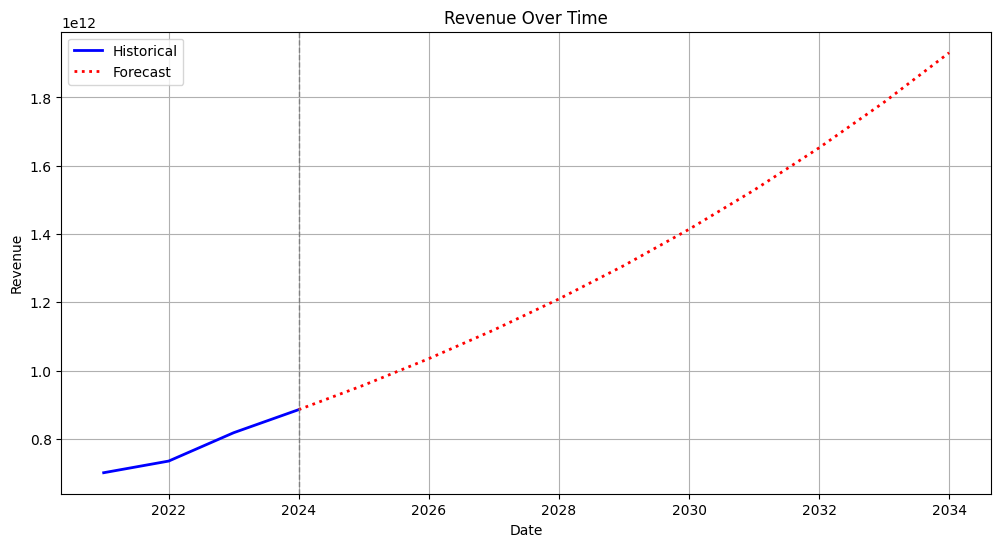

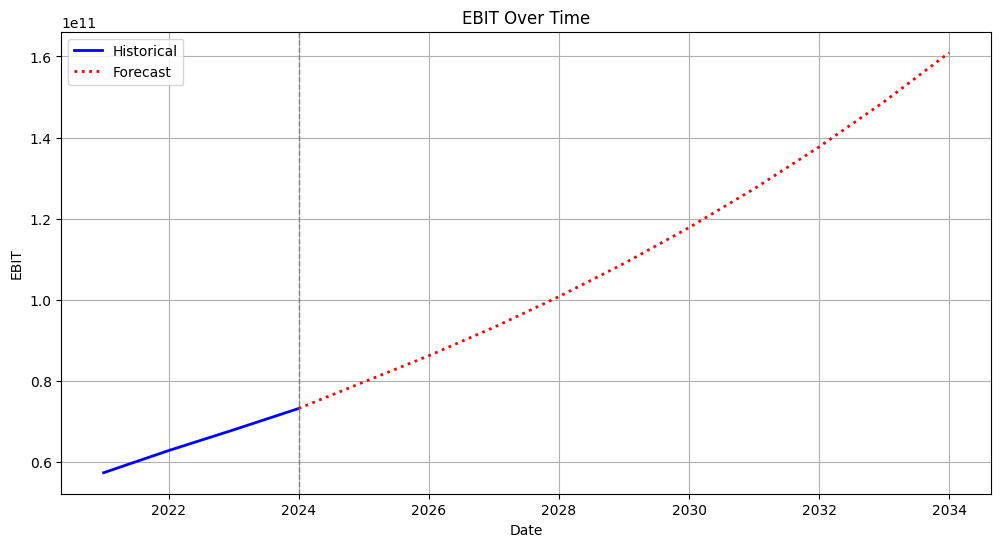

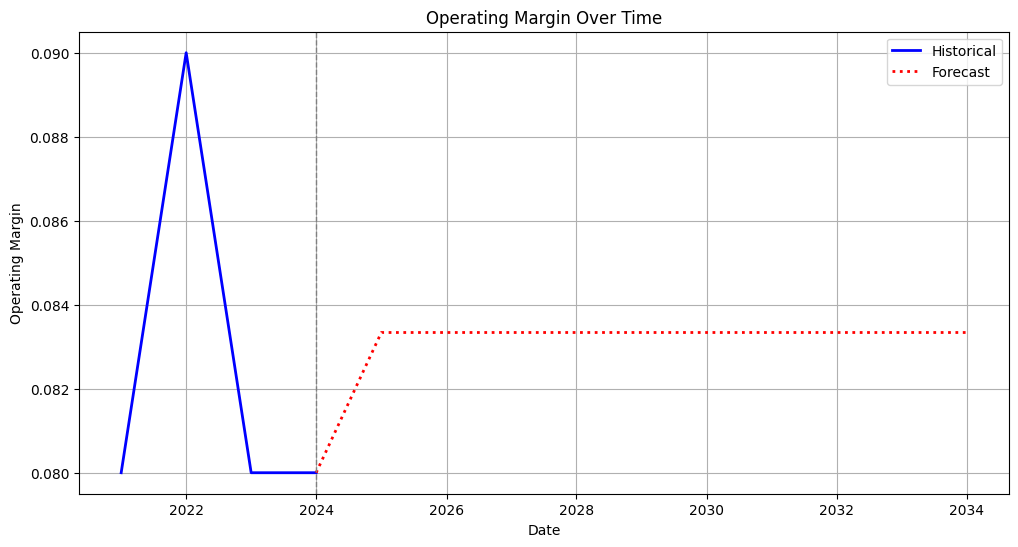

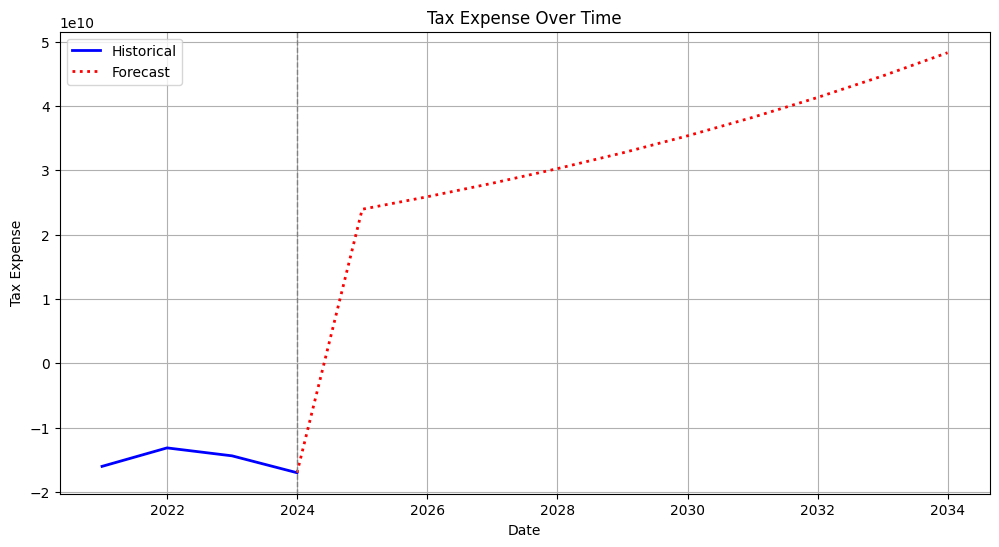

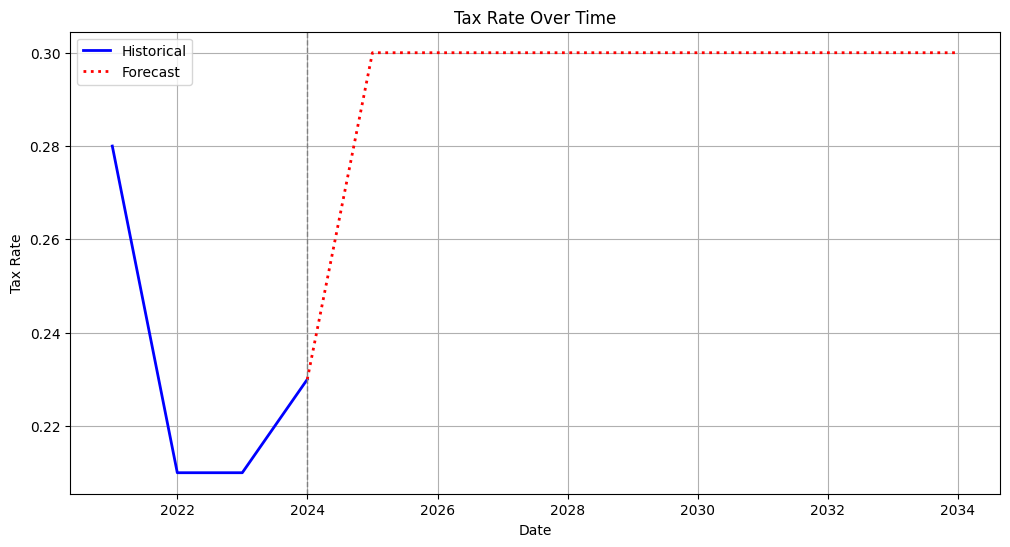

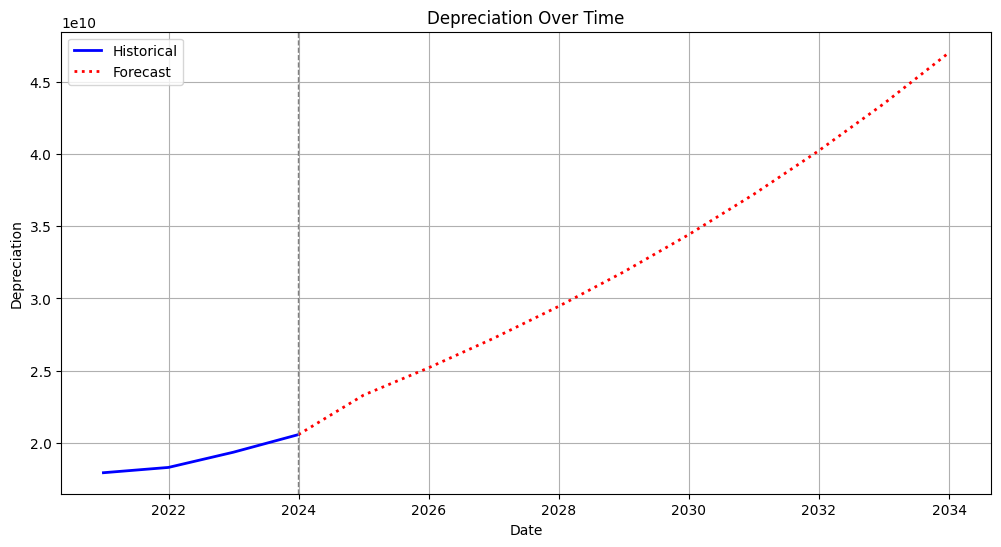

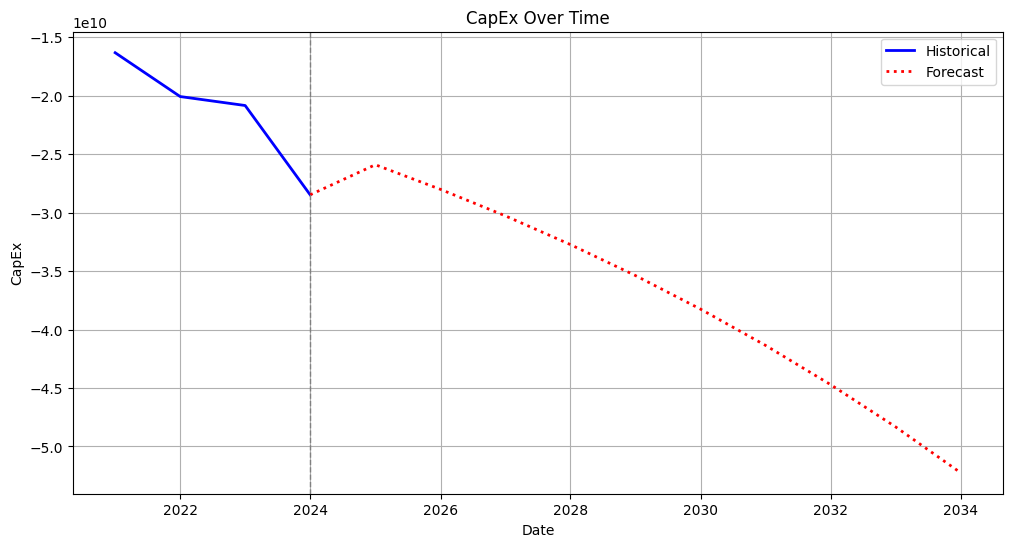

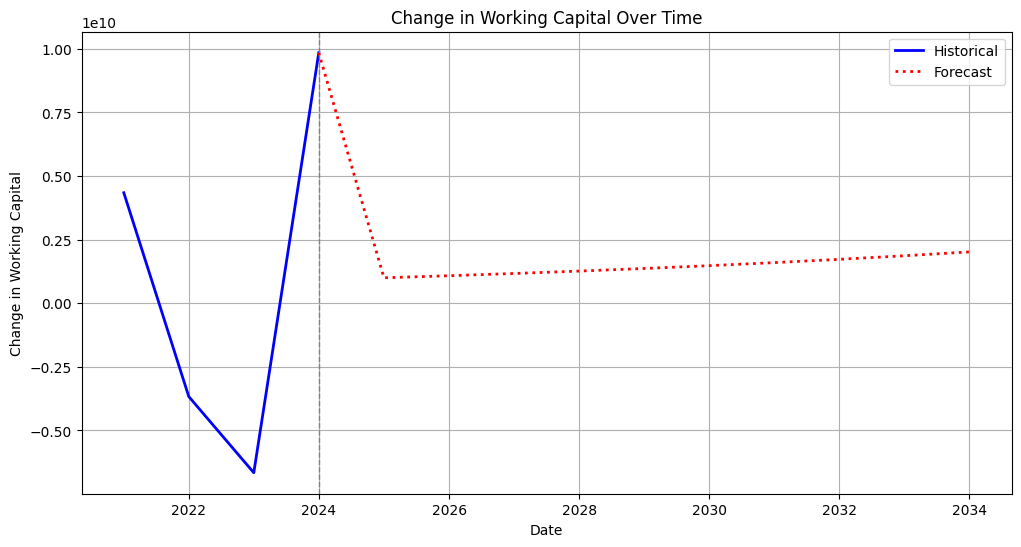

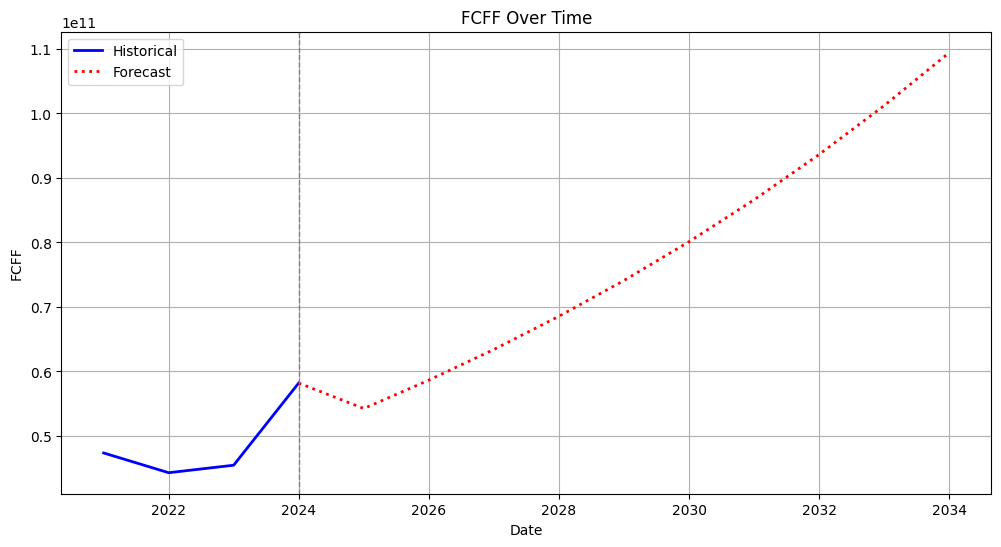

In [635]:
# Graphs

last_historical_date = pd.to_datetime(df.columns[-1])

# Plot each column
for column in combined_df.columns:
    plt.figure(figsize=(12, 6))

    # Plot historical data
    plt.plot(combined_df.loc[:last_historical_date].index, combined_df.loc[:last_historical_date, column], color='blue', linewidth=2, label='Historical')

    # Plot forecast data
    plt.plot(combined_df.loc[last_historical_date:].index, combined_df.loc[last_historical_date:, column], color='red', linestyle='dotted', linewidth=2, label='Forecast')

    # Add horizontal line to separate
    plt.axvline(pd.to_datetime(last_historical_date), color='grey', linestyle='--', linewidth=1)

    # Customize the plot
    plt.title(f"{column} Over Time")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()
    plt.grid()


In [636]:
print("Income Statement Keys:")
print(income_stmt.index)

Income Statement Keys:
Index(['Tax Effect Of Unusual Items', 'Tax Rate For Calcs',
       'Normalized EBITDA', 'Total Unusual Items',
       'Total Unusual Items Excluding Goodwill',
       'Net Income From Continuing Operation Net Minority Interest',
       'Reconciled Depreciation', 'Reconciled Cost Of Revenue', 'EBITDA',
       'EBIT', 'Net Interest Income', 'Interest Expense', 'Interest Income',
       'Normalized Income',
       'Net Income From Continuing And Discontinued Operation',
       'Total Expenses', 'Rent Expense Supplemental',
       'Total Operating Income As Reported', 'Diluted Average Shares',
       'Basic Average Shares', 'Diluted EPS', 'Basic EPS',
       'Diluted NI Availto Com Stockholders', 'Net Income Common Stockholders',
       'Otherunder Preferred Stock Dividend', 'Net Income',
       'Net Income Including Noncontrolling Interests',
       'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income',
       'Net Non Operating Interest Income Expens

In [637]:
# Discount Rate

#tnx = yf.Ticker("^TNX")

# Get the latest ^TNX closing price as the risk-free rate (divided by 100 to convert percentage)
#tnx_hist = tnx.history(period="1d")
#risk_free_rate = tnx_hist['Close'].iloc[-1] / 100
#print(f"10Y rate : {risk_free_rate:.2%}")

# Get the country info
country = stock.info.get('country', 'N/A')

# Determine the risk-free rate based on the country
if country == 'United States':
    # Get the latest ^TNX value
    tnx = yf.Ticker("^TNX")
    risk_free_rate = tnx.history(period="1d")['Close'].iloc[-1] / 100
else:
    # Prompt user to input the risk-free rate
    risk_free_rate = float(input("Please enter the risk-free rate: ")) / 100

print(f"Risk-Free Rate: {risk_free_rate:.2%}")

# Get market data for the Stock
market_cap = stock.info['marketCap']
total_debt = stock.balance_sheet.loc['Total Debt'][0]
interest_expense = stock.income_stmt.loc['Interest Expense Non Operating'][0]  # Normally the name is Interest Expense, but If error print(income_stmt.index) to see which name Interest Expenses have
#print(total_debt)
#print(interest_expense)

# Assumptions
equity_risk_premium = 0.046  # Input Data From Damodaran https://pages.stern.nyu.edu/~adamodar/
beta = stock.info['beta']
print(f"Beta : {beta:}")
tax_rate = 0.21  # US corporate tax rate

# Calculate Cost of Equity using CAPM
cost_of_equity = risk_free_rate + beta * (equity_risk_premium)
print(f"CoE: {cost_of_equity:.2%}")

# Calculate Cost of Debt
cost_of_debt = interest_expense / total_debt if total_debt else 0
print(f"CoD: {cost_of_debt:.2%}")

# Calculate weights
weight_of_equity = market_cap / (market_cap + total_debt)
weight_of_debt = total_debt / (market_cap + total_debt)
print(f"Weight Equity: {weight_of_equity:.2%}")
print(f"Weight Debt: {weight_of_debt:.2%}")

# Calculate WACC
wacc = (weight_of_equity * cost_of_equity) + (weight_of_debt * cost_of_debt * (1 - tax_rate))

print(f"WACC: {wacc:.2%}")

Please enter the risk-free rate: 10.24
Risk-Free Rate: 10.24%
Beta : 0.12
CoE: 10.79%
CoD: 10.41%
Weight Equity: 93.52%
Weight Debt: 6.48%
WACC: 10.63%


In [638]:
# Discounted FCFF

# Calculate discount factors only for the forecasted years (2024 onward)
#forecast_start = '2025-12-31'

last_date = pd.to_datetime(df.columns[-1])
forecast_start = last_date + pd.DateOffset(years=2)
forecast_df = combined_df.loc[forecast_start:]
discount_factors = np.array([(1 + wacc) ** i for i in range(1, len(forecast_df.index) + 1)])

# Calculate Present Value of forecasted FCFF
forecast_df.loc[:,'Present Value of FCFF'] = forecast_df['FCFF'] / discount_factors

# Set present value of FCFF to zero for years 2020-2023
combined_df['Present Value of FCFF'] = 0
combined_df.loc[forecast_start:, 'Present Value of FCFF'] = forecast_df['Present Value of FCFF']

# Calculate Total Present Value of forecasted FCFF
total_present_value = combined_df['Present Value of FCFF'].sum()

#print(combined_df[['FCFF', 'Present Value of FCFF']])
print(f"Total Present Value of Future Cash Flows: ${total_present_value:,.2f}")
combined_df

Total Present Value of Future Cash Flows: $435,957,520,407.73


<ipython-input-638-4ac3885dd369>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df.loc[:,'Present Value of FCFF'] = forecast_df['FCFF'] / discount_factors


,Revenue,EBIT,Operating Margin,Tax Expense,Tax Rate,Depreciation,CapEx,Change in Working Capital,FCFF,Present Value of FCFF
2020-12-31,701092586000.00,57447281000.00,0.08,-16029226000.00,0.28,17939624000.00,-16330230000.00,4343446000.00,47370895000.00,0.00
2021-12-31,735197307000.00,62907658000.00,0.09,-13157576000.00,0.21,18305881000.00,-20077816000.00,-3670026000.00,44308121000.00,0.00
2022-12-31,818225636000.00,68011617000.00,0.08,-14392375000.00,0.21,19359205000.00,-20844337000.00,-6662570000.00,45471540000.00,0.00
2023-12-31,885739821000.00,73275983000.00,0.08,-17016748000.00,0.23,20577439000.00,-28479210000.00,9847893000.00,58205357000.00,0.00
2024-12-31,957524221348.88,79798812358.64,0.08,23939643707.59,0.30,23310754330.40,-25908220448.95,1000355182.94,54262057715.44,0.00
2025-12-31,1035126357347.99,86266072560.68,0.08,25879821768.21,0.30,25199964323.69,-28007940959.35,1081428535.68,58659702692.50,53025344432.98
2026-12-31,1119017724864.53,93257469066.07,0.08,27977240719.82,0.30,27242284523.04,-30277832409.54,1169072443.19,63413752902.94,51816817692.04
2027-12-31,1209708031944.19,100815480274.61,0.08,30244644082.38,0.30,29450123678.80,-32731686229.64,1263819413.25,68553093054.62,50635835079.28
2028-12-31,1307748295700.55,108986027229.61,0.08,32695808168.88,0.30,31836896203.14,-35384411570.31,1366245110.48,74108948804.04,49481768822.90
2029-12-31,1413734190190.59,117818752625.48,0.08,35345625787.65,0.30,34417103673.47,-38252125887.82,1476971854.00,80115076477.49,48354005458.96


In [639]:
# Terminal Value

perpetuity_growth = 0.04 # Key assumption
last_fcff = combined_df['FCFF'].iloc[-1]
perpetuity_value = ((last_fcff * (1 + perpetuity_growth)) / (wacc - perpetuity_growth)) / discount_factors[-1]

print(f"PV of Terminal Value: ${perpetuity_value:,.2f}")

PV of Terminal Value: $692,113,810,644.60


In [640]:
#print("Balance Sheet Keys:")
#print(stock.balance_sheet.index)

In [641]:
# Calculate de Target Price

Equity_Value = total_present_value + perpetuity_value - stock.balance_sheet.loc['Total Debt'][0] + stock.balance_sheet.loc['Cash Cash Equivalents And Short Term Investments'][0] #- stock.balance_sheet.loc['Minority Interest'][0]
#target_price = (Equity_Value / stock.balance_sheet.loc['Ordinary Shares Number'][0])

currency = stock.info.get('financialCurrency', 'N/A')

if country == 'United States':
    target_price = (Equity_Value / stock.balance_sheet.loc['Ordinary Shares Number'][0])
elif currency == 'USD':
    fx = yf.Ticker("MXN=X")
    mxn = fx.history(period="1d")['Close'].iloc[-1]
    target_price = (Equity_Value / stock.balance_sheet.loc['Ordinary Shares Number'][0]) * mxn
else:
    target_price = (Equity_Value / stock.balance_sheet.loc['Ordinary Shares Number'][0])

print(f"The Target Price of {ticker}: ${target_price:,.2f}")

# Calculate the Expected Total Return

etr = target_price / stock.history(period="1d")['Close'].iloc[-1] -1
print(f"The Expected Total Return of {ticker} is: {etr*100:,.2f}%")


The Target Price of WALMEX.MX: $62.68
The Expected Total Return of WALMEX.MX is: 0.30%


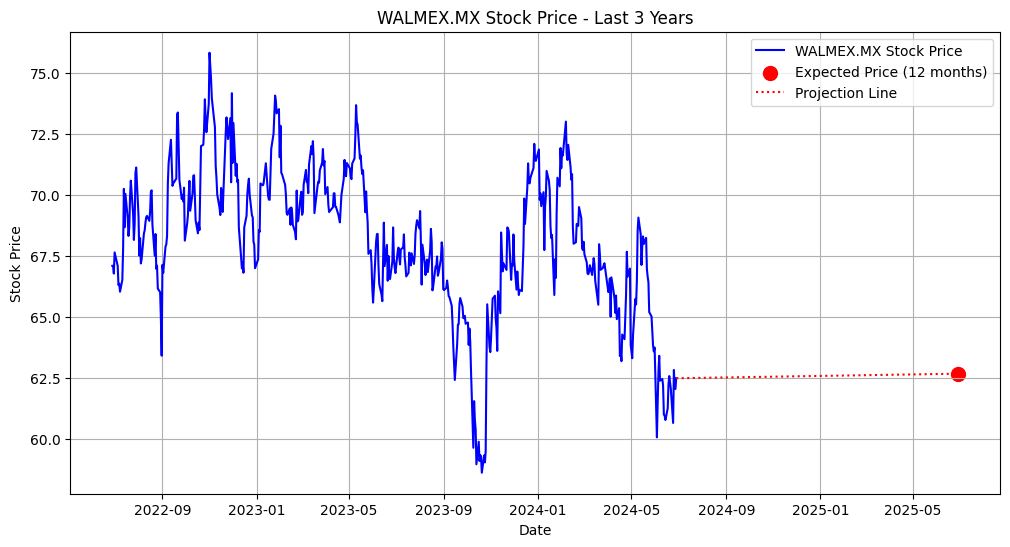

In [642]:
# Get historical market data for the last 3 years
data = stock.history(period="2y")

# Define your expected stock price in 12 months
expected_date = data.index[-1] + pd.DateOffset(months=12)

# Plot the historical stock prices
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label=f"{ticker} Stock Price", color='blue')

# Plot the expected price
plt.scatter(expected_date, target_price, color='red', s=100, label="Expected Price (12 months)")
plt.plot([data.index[-1], expected_date], [data['Close'].iloc[-1], target_price], color='red', linestyle='dotted', label="Projection Line")

# Customize the plot
plt.title(f"{ticker} Stock Price - Last 3 Years")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()

In [643]:
# Multiples

entreprise_value = total_present_value + perpetuity_value

ev_revenue = entreprise_value / combined_df.loc['2022-12-31':'2026-12-31','Revenue']
ev_EBIT = entreprise_value / combined_df.loc['2022-12-31':'2026-12-31','EBIT']
ev_EBITDA = entreprise_value / (combined_df.loc['2022-12-31':'2026-12-31','EBIT'] + combined_df.loc['2022-12-31':'2026-12-31','Depreciation'])
ev_FCFF = entreprise_value / combined_df.loc['2022-12-31':'2026-12-31','FCFF']

multiples_df = pd.DataFrame({
    'EV / Revenue': ev_revenue,
    'EV / EBIT': ev_EBIT,
    'EV / EBITDA': ev_EBITDA,
    'EV / FCFF': ev_FCFF
})


print("\nMultiples Table:")
multiples_df


Multiples Table:


,EV / Revenue,EV / EBIT,EV / EBITDA,EV / FCFF
2022-12-31,1.38,16.59,12.91,24.81
2023-12-31,1.27,15.39,12.02,19.38
2024-12-31,1.18,14.14,10.94,20.79
2025-12-31,1.09,13.08,10.12,19.23
2026-12-31,1.01,12.10,9.36,17.79


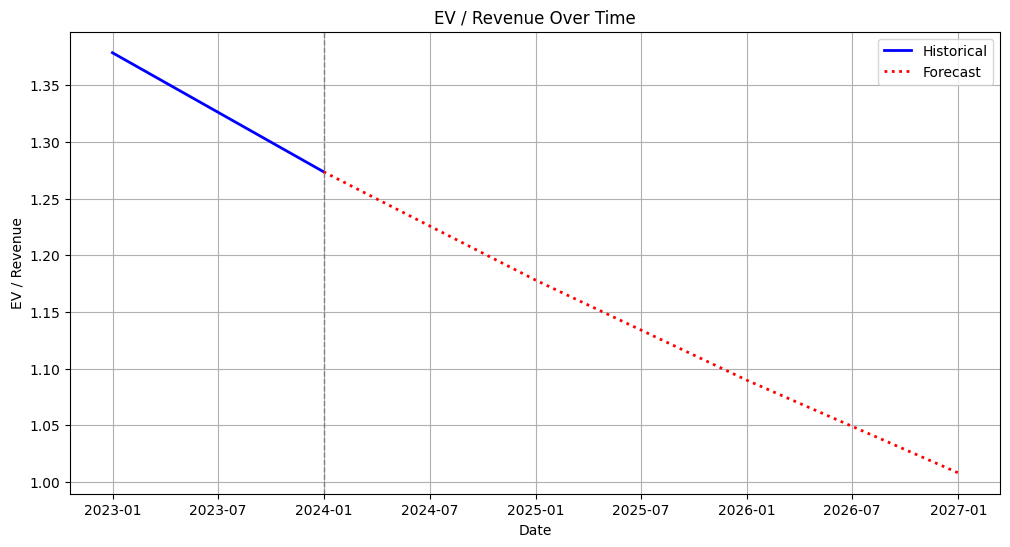

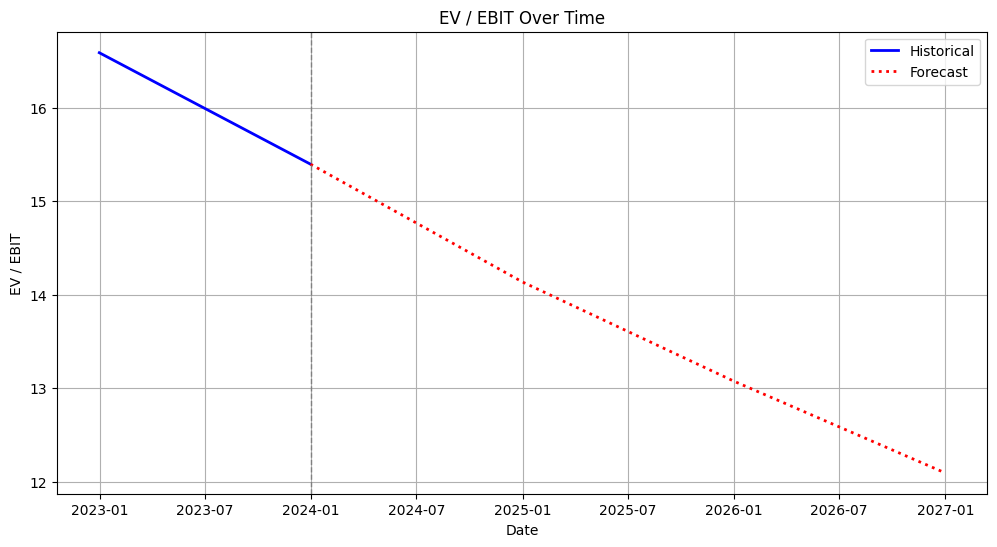

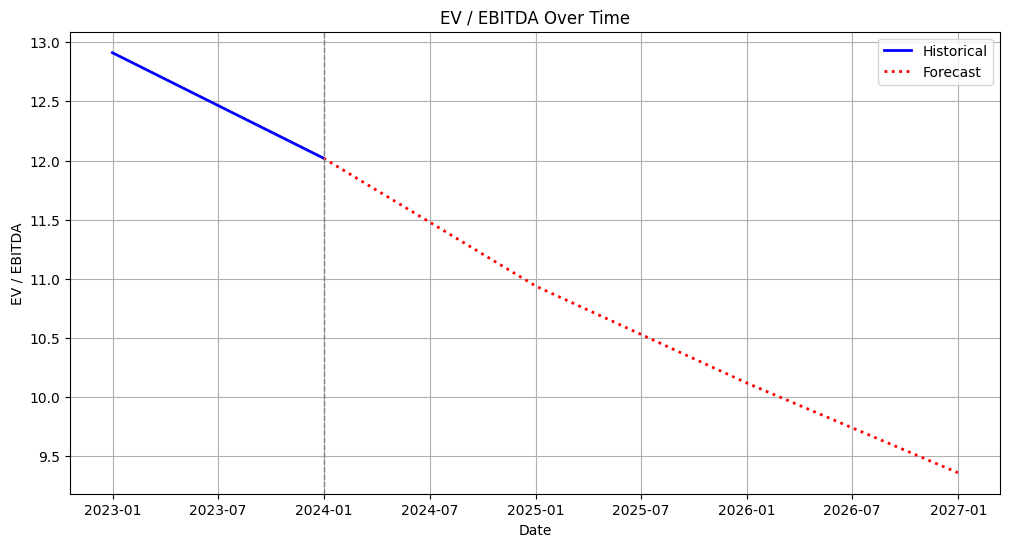

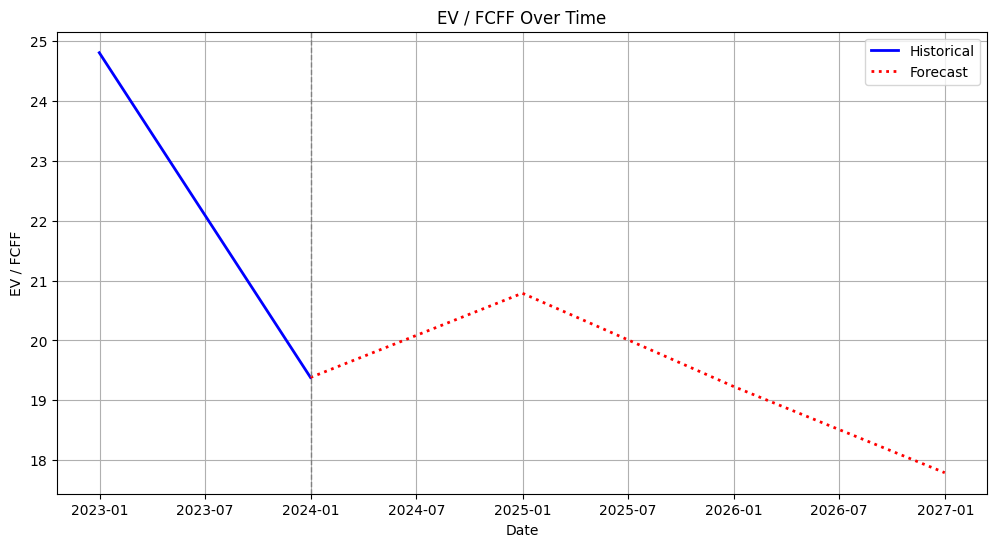

In [644]:
# Graphs

# Define colors
colors = ['blue' if date.year == 2023 else 'red' for date in multiples_df.index]

for column in multiples_df.columns:
    plt.figure(figsize=(12, 6))

    # Plot historical data
    plt.plot(multiples_df.loc[:last_historical_date].index, multiples_df.loc[:last_historical_date, column], color='blue', linewidth=2, label='Historical')

    # Plot forecast data
    plt.plot(multiples_df.loc[last_historical_date:].index, multiples_df.loc[last_historical_date:, column], color='red', linestyle='dotted', linewidth=2, label='Forecast')

    # Add horizontal line to separate
    plt.axvline(pd.to_datetime(last_historical_date), color='grey', linestyle='--', linewidth=1)

    # Customize the plot
    plt.title(f"{column} Over Time")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.legend()
    plt.grid()
